In [18]:
import json
import os
import pathlib
import random
import sys

import numpy as np
import pandas as pd
from implicit.als import AlternatingLeastSquares

project_path = pathlib.Path(os.getcwd()).parent
sys.path.append(project_path.as_posix())

from catboost import CatBoostRanker, Pool
from scipy.sparse import csr_matrix

from src.model.collaborative.utils import (compute_decay_weight,
                                           create_als_train_data,
                                           create_catboost_train_data,
                                           create_mappings,
                                           get_catboost_inference_data,
                                           sort_preds)

BUYER_STREAM = "../data/raw/AAA_rec_system_data_one_file"
EVENTS_DATA = "../data/raw/events.csv"
CATEGORIES_DATA = "../data/raw/categories.csv"

In [19]:
data = pd.read_parquet(BUYER_STREAM)
events = pd.read_csv(EVENTS_DATA)
categories = pd.read_csv(CATEGORIES_DATA)

# Обработка данных

In [20]:
data = data[["user_id", "item_id", "microcat_id", "event_date", "eid"]]

# Чистим мусор, приводим человеческие типы
data = data.dropna()
data.user_id = data.user_id.astype("int64")
data.microcat_id = data.microcat_id.astype("int64")

# Оставляем только те категории, по которым у нас есть инфа
data = data[data.microcat_id.isin(set(categories.microcat_id))]

In [21]:
# Оставляем только контактные взаимодействия

contacts_eid = events[events["IsContact"].fillna(False)]["EventType_ext"].unique()
data = data[data["eid"].isin(contacts_eid)]

/var/folders/3t/8pkw9rb128v3s69ldrh5nqhm0000gn/T/ipykernel_14922/3493690669.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  contacts_eid = events[events["IsContact"].fillna(False)]["EventType_ext"].unique()


In [22]:
print(data.event_date.min())
print(data.event_date.max())
print(data.user_id.nunique())

2025-04-01 00:00:04
2025-04-30 23:59:57
239749


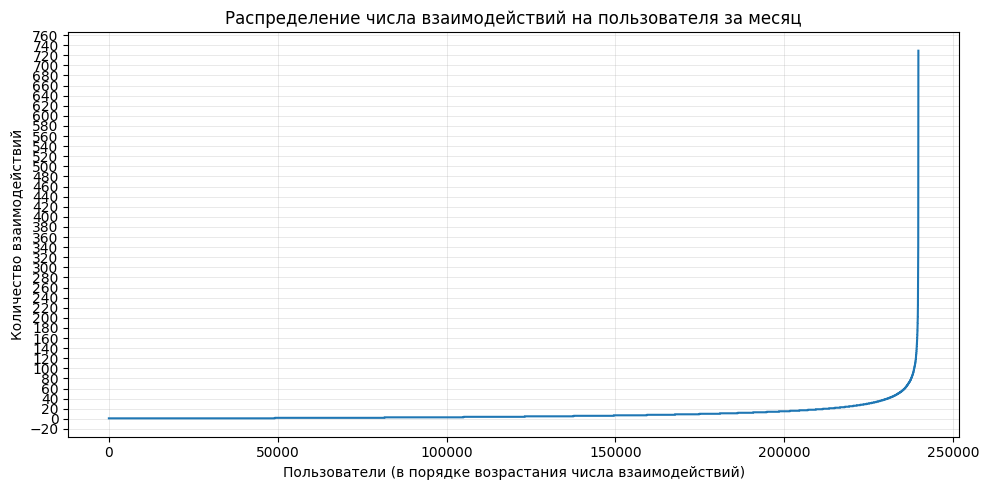

In [27]:
# Подбираем примерно, какие категории не стоит учиться предсказывать, я думаю, что меньше 300 взаимодействий за месяц о микрокатегории это мало

import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

series = data.groupby("user_id").size()
sorted_series = series.sort_values()

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(sorted_series.values)

ax.set_title("Распределение числа взаимодействий на пользователя за месяц")
ax.set_xlabel("Пользователи (в порядке возрастания числа взаимодействий)")
ax.set_ylabel("Количество взаимодействий")
ax.yaxis.set_major_locator(MultipleLocator(20))

ax.grid(which="major", axis="both", linewidth=0.5, alpha=0.4)
plt.tight_layout()

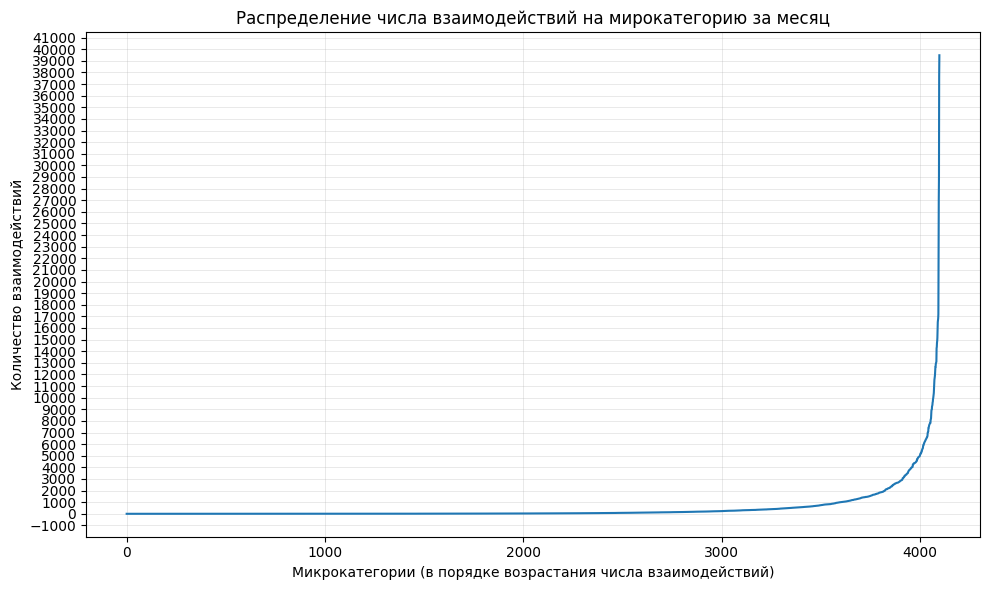

In [42]:
# Подбираем примерно, какие категории не стоит учиться предсказывать, я думаю, что меньше 300 взаимодействий за месяц о микрокатегории это мало

series = data.groupby("microcat_id").size()
sorted_series = series.sort_values()

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(sorted_series.values)

ax.set_title("Распределение числа взаимодействий на мирокатегорию за месяц")
ax.set_xlabel("Микрокатегории (в порядке возрастания числа взаимодействий)")
ax.set_ylabel("Количество взаимодействий")
ax.yaxis.set_major_locator(MultipleLocator(1000))

ax.grid(which="major", axis="both", linewidth=0.5, alpha=0.4)
plt.tight_layout()

In [ ]:
# Не будем делать рекомендации для пользователей, которые мало обоснованы. Также не стоит учиться рекомендовать слабые микрокатегории, которые редко встречаются, алгоритм вряд ли сможет уловить связи и прогноз будет зашумляться сильно

MIN_USERS_INTERACTIONS = 20
MIN_MICROCATS_INTERACTIONS = 300

users_filter = data.groupby("user_id")["item_id"].apply(lambda x: len(set(x)))

microcats_filter = data.groupby("microcat_id")["user_id"].apply(lambda x: len(set(x)))

users_filter = users_filter[users_filter > MIN_USERS_INTERACTIONS].index
microcats_filter = microcats_filter[microcats_filter > MIN_MICROCATS_INTERACTIONS].index
data = data[
    (data["user_id"].isin(users_filter)) & (data["microcat_id"].isin(microcats_filter))
]

In [13]:
data['user_id'].nunique()

15365

In [14]:
# Так как в датасете может быть несколько взаимодействий с одним и тем же объявлением - оставляем только последнее взаимодействие

data = data.sort_values(["user_id", "item_id", "event_date"]).drop_duplicates(
    subset=["user_id", "item_id"], keep="last"
)

In [15]:
data['user_id'].nunique()

15365

In [16]:
# Уберем пользователей, у которых меньше 20 взаимодействий финальных (тк в первый раз мы фильтровали в целом по любым взаимодействиям учитывая даже те, что относятся к одному и тому же объекту)
mask = data.groupby("user_id").size() > 20
users_needed = mask[mask].index.tolist()
data = data[data["user_id"].isin(users_needed)]

# Затем составляем валидационную (предпоследние 5 взаимодействий) и тестовую (нужна только лишь для того, чтобы собрать валидацию под обучение катбуста) выборки
# Самые последние 5 взаимодействий для каждого пользователя (test) оставим на прод инференс итоговый (симулируем прод, когда нам нужно обучить модельки и скорить свежие данные, будем считать, что это они)
test_valid = data.sort_values(["user_id", "event_date"]).groupby("user_id").tail(10)

test = test_valid.sort_values(["user_id", "event_date"]).groupby("user_id").tail(5)
valid = test_valid[~test_valid.index.isin(test.index)]
train = data[~data.index.isin(test_valid.index)]

In [17]:
data['user_id'].nunique()

12225

In [14]:
# В рамках каждого пользователя будем хранить уникальные микрокатегории, с которыми он провзаимодействовал в течение трейн выборки
train_microcat_interactions = (
    train.groupby("user_id")["microcat_id"].apply(lambda x: set(x)).reset_index()
)

# Здесь сохраним все микрокатегории, с которыми хоть раз провзаимодействовал любой из пользователей
all_train_microcats = set(train.microcat_id)

# Оставляем на валидацию и тест только те категории по каждому пользователю, которые не встречались у него в трейне, при этом второе условие на то, чтобы микрокатегория была в общем пуле микрокатегорий, по которым хоть какая то инфа была, на этом наборе будем обучать катбуст
valid_frame = valid[
    valid.apply(
        lambda x: (
            x.microcat_id
            not in train_microcat_interactions[
                train_microcat_interactions["user_id"] == x.user_id
            ].microcat_id.iloc[0]
        )
        and (x.microcat_id in all_train_microcats),
        axis=1,
    )
]

# Получаем 5 последних взаимоедействий с категориями по каждому пользователю (из трейна), которые мы будем использовать на этапе обучения катбуста (доп фичи)
last_interactions_valid = (
    train.sort_values(["user_id", "event_date"])
    .groupby("user_id")
    .apply(lambda x: list(set(x.microcat_id[-5:])))
    .reset_index()
    .rename(columns={0: "last_interactions"})
)

/var/folders/3t/8pkw9rb128v3s69ldrh5nqhm0000gn/T/ipykernel_81239/1166309483.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: list(set(x.microcat_id[-5:])))


In [15]:
# Получим мапперы на новые индексы для ALS
train_data, user_to_index, microcat_to_index = create_mappings(train)

# Сразу подготовим новые индексы для выборки катбуста тоже
valid_frame["user_idx"] = valid_frame.user_id.map(user_to_index)
valid_frame["microcat_idx"] = valid_frame.microcat_id.map(microcat_to_index)

/Users/alfa/Downloads/aaa-t-recs/src/model/collaborative/utils/data.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interactions["user_idx"] = interactions["user_id"].map(user_to_index)
/Users/alfa/Downloads/aaa-t-recs/src/model/collaborative/utils/data.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interactions["microcat_idx"] = interactions["microcat_id"].map(microcat_to_index)
/var/folders/3t/8pkw9rb128v3s69ldrh5nqhm0000gn/T/ipykernel_81239/2215947369.py:5: SettingWithCopyWarning: 
A value i

In [16]:
# Первый этап создания весов взаимодействий: Посчитаем затухающие коэфиценты к каждому взаимодействию полльзователя с объявлениями

last_interactions = (
    train_data.groupby("user_id")["event_date"].max().reset_index()
)  # время последнего взаимодействия каждого пользователя
train_data["weight"] = train_data.apply(
    lambda row: compute_decay_weight(row, last_interactions), axis=1
)

/var/folders/3t/8pkw9rb128v3s69ldrh5nqhm0000gn/T/ipykernel_81239/2512110032.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["weight"] = train_data.apply(


In [17]:
# Второй этап создания весов взаимодействий: Просуммируем взаимодействия внутри одной микрокатегории, чтобы учитывать этот аспект тоже, помимо затухающего взаимодействия со временем

train_data = create_als_train_data(train_data)

In [80]:
train_data

,user_id,item_id,microcat_id,event_date,eid,user_idx,microcat_idx,weight
0,558,2064080250155,3527,2025-04-04 17:48:49,857,0,6,0.655738
1,558,2074878503475,4275,2025-04-17 09:21:33,857,0,3,1.939361
2,558,2050571250066,4787,2025-04-13 17:42:34,4675,0,4,0.294118
3,558,2079796752076,5483,2025-04-22 11:22:15,857,0,1,3.422531
4,558,2073856500405,5986,2025-04-18 10:41:59,303,0,10,0.454545
...,...,...,...,...,...,...,...,...
117535,1893593250002,2074145501724,80720750007,2025-04-29 18:51:35,857,12224,43,2.000000
117536,1893593250002,2074975502383,299603250002,2025-04-28 05:54:09,5942,12224,441,0.625000
117537,1893593250002,1955159750512,299608250003,2025-04-29 19:21:16,857,12224,434,1.000000
117538,1893593250002,2084909507196,338647750001,2025-04-29 19:08:54,857,12224,71,1.000000


# Трейн ALS

In [84]:
# Собираем спарс матрицу для трейна ALS

user_ids = train_data.user_id.unique().tolist()
item_ids = train_data.microcat_id.unique().tolist()

sparse_matrix = csr_matrix(
    (train_data.weight, (train_data.user_idx, train_data.microcat_idx)),
    shape=(len(user_ids), len(item_ids)),
)

In [86]:
best_parameters = {
    "factors": 25,
    "regularization": 0.644932356306179,
    "alpha": 11.51942080560729,
    "iterations": 38,
}
als = AlternatingLeastSquares(**best_parameters)

als.fit(sparse_matrix)

100%|██████████| 38/38 [00:01<00:00, 26.45it/s]


# Трейн катбуста

In [87]:
# Вектора пользователей и микрокатегорий
user_vectors = als.user_factors
item_vectors = als.item_factors

# Длина каждого вектора, понадобится для катбуста для определения названий колонок
user_vector_length = user_vectors[0].shape[0]
item_vector_length = item_vectors[0].shape[0]

# Добавляем дополнительный ключ (понадобится дальше)
microcat_to_index[-1] = -1

In [88]:
# Катбуст будет кушать: 5 последних микрокатегорий | предсказываемый кандидат | скор из ALS предсказываемого кандидата и пользователя | усредненный вектор 5 последних микрокатегорий | вектор ALS пользователя | вектор ALS таргет микрокатегории

catboost_train_df = create_catboost_train_data(
    valid_frame,
    user_to_index,
    microcat_to_index,
    user_vectors,
    item_vectors,
    last_interactions_valid,
    all_train_microcats,
)

In [138]:
cat_features = [
    "last_microcat_1",
    "last_microcat_2",
    "last_microcat_3",
    "last_microcat_4",
    "last_microcat_5",
    "target_microcat",
]

num_features = ["target_score"]

last_microcat_embed_values_names = [
    f"last_microcat_embed_value_{i + 1}" for i in range(item_vector_length)
]

item_embed_values_names = [
    f"item_embed_value_{i + 1}" for i in range(item_vector_length)
]

user_embed_values_names = [
    f"user_embed_value_{i + 1}" for i in range(user_vector_length)
]

target_col = "target"

best_parameters_cb_ranker = {
    "iterations": 80,
    "learning_rate": 0.05757465490024515,
    "depth": 15,
    "l2_leaf_reg": 62.318552538223045,
    "bagging_temperature": 0.7818961168645023,
    "random_strength": 1.7908624833439135,
    "border_count": 195,
    "subsample": 0.9464312007711417,
}

train_cb_ranker = catboost_train_df.sort_values("user_id").reset_index(drop=True)
ranker_train_pool = Pool(
    data=train_cb_ranker[
        cat_features
        + num_features
        + last_microcat_embed_values_names
        + item_embed_values_names
        + user_embed_values_names
    ],
    label=train_cb_ranker[target_col],
    group_id=train_cb_ranker["user_id"],
    cat_features=cat_features,
)

ranker = CatBoostRanker(**best_parameters_cb_ranker)
ranker.fit(ranker_train_pool)

Groupwise loss function. OneHotMaxSize set to 10
0:	total: 709ms	remaining: 56s
1:	total: 1.17s	remaining: 45.6s
2:	total: 1.22s	remaining: 31.2s
3:	total: 1.88s	remaining: 35.8s
4:	total: 2.34s	remaining: 35.2s
5:	total: 2.41s	remaining: 29.7s
6:	total: 2.91s	remaining: 30.4s
7:	total: 3.39s	remaining: 30.5s
8:	total: 3.91s	remaining: 30.8s
9:	total: 4.37s	remaining: 30.6s
10:	total: 4.81s	remaining: 30.2s
11:	total: 5.24s	remaining: 29.7s
12:	total: 5.67s	remaining: 29.2s
13:	total: 6.09s	remaining: 28.7s
14:	total: 6.52s	remaining: 28.3s
15:	total: 6.57s	remaining: 26.3s
16:	total: 7s	remaining: 25.9s
17:	total: 7.42s	remaining: 25.6s
18:	total: 7.66s	remaining: 24.6s
19:	total: 8.1s	remaining: 24.3s
20:	total: 8.54s	remaining: 24s
21:	total: 8.77s	remaining: 23.1s
22:	total: 9.2s	remaining: 22.8s
23:	total: 9.33s	remaining: 21.8s
24:	total: 9.77s	remaining: 21.5s
25:	total: 10.2s	remaining: 21.2s
26:	total: 10.6s	remaining: 20.9s
27:	total: 10.7s	remaining: 19.9s
28:	total: 11.1s	r

# Получили два модельных артефакта, теперь - как будем инференсить

Я думаю, что тк в проде рекомендации для одного человека не просчитываются отдельно, тк это батч модель. То при старте приложения заскорим весь датасет вот таким образом, как ниже, заранее подготовив два артефакта и набор данных: айдишники пользователей + их последние 5 взаимодействий, которые в следующей ячейке определяются. Сам скоринг уже идет дальше

In [139]:
# Получаем последние 5 взаимодействий по каждому пользователю


def filter_microcat_item_id(tdf):
    return pd.Series(
        {
            "last_items": tdf.item_id.tolist(),
            "last_interactions": list(set(tdf.microcat_id[-5:])),
        }
    )


last_interactions_prod = (
    test.sort_values(["user_id", "event_date"])
    .groupby("user_id")
    .apply(filter_microcat_item_id)
    .reset_index()
)

/var/folders/3t/8pkw9rb128v3s69ldrh5nqhm0000gn/T/ipykernel_81239/2876231939.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(filter_microcat_item_id)


In [140]:
# Получаем предсказания ALS

user4pred = np.array(
    [user_to_index[i] for i in last_interactions_prod.user_id.tolist()]
)
recommendations, _ = als.recommend(
    user4pred, sparse_matrix[user4pred], N=100, filter_already_liked_items=True
)

last_interactions_prod["preds"] = recommendations.tolist()

In [93]:
# Делаем пул для инференса катбуста

catboost_prod_df = get_catboost_inference_data(
    last_interactions_prod,
    user_to_index,
    microcat_to_index,
    user_vectors,
    item_vectors,
    last_interactions_prod,
)

prod_pool = Pool(
    data=catboost_prod_df[
        cat_features
        + num_features
        + last_microcat_embed_values_names
        + item_embed_values_names
        + user_embed_values_names
    ],
    cat_features=cat_features,
)

In [141]:
# Инференс катбуста

probs_ranker = ranker.predict(prod_pool)
catboost_prod_df["ranker_scores"] = probs_ranker

catboost_ranker_results = (
    catboost_prod_df.groupby("user_id")
    .apply(sort_preds, model_col="ranker_scores")
    .reset_index()
)
catboost_ranker_results.user_id = catboost_ranker_results.user_id.astype("int64")

/var/folders/3t/8pkw9rb128v3s69ldrh5nqhm0000gn/T/ipykernel_81239/1582414945.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(sort_preds, model_col="ranker_scores")


In [142]:
# Финализируем табличку. Сюда можно изначально в last_interactions_prod добавить сами объявления (последние 5 по каждому пользователю), в нее же сохранить финальные предсказания по объявлениям из фаиса. И потом сохранить куда нибудь в проект. Чтобы на фронтенде было удобно показывать по каждому объявлению инфу по микрокатегориям (предыдущим и предсказанным и т д)

last_interactions_prod = pd.merge(
    last_interactions_prod, catboost_ranker_results, on="user_id"
)
last_interactions_prod

,user_id,last_items,last_interactions,preds,ranker_scores
0,558,"[2065582250540, 2083462751217, 2039245001085, ...","[304851500001, 5997]","[39, 211, 11, 354, 533, 56, 194, 458, 37, 30, ...","[458, 165, 57, 176, 194, 56, 294, 11, 533, 30,..."
1,2512,"[1812988750242, 1982841750845, 1853048500843, ...","[304851500001, 4562, 591684000001]","[165, 37, 57, 156, 10, 40, 211, 210, 30, 587, ...","[165, 10, 57, 156, 210, 587, 36, 30, 1, 364, 2..."
2,2770,"[2082991500440, 2019517250433, 2068930750296, ...","[605520500001, 242818500001, 2477, 36283525000...","[152, 125, 246, 62, 46, 225, 68, 73, 322, 75, ...","[79, 62, 75, 178, 61, 73, 135, 359, 225, 256, ..."
3,2892,"[668910000552, 817683000728, 1906810252033, 20...","[5231, 10750010, 5927]","[10, 165, 57, 156, 162, 8, 155, 261, 159, 36, ...","[36, 165, 10, 261, 156, 57, 155, 159, 162, 8, ..."
4,3197,"[1180328250200, 1964398000228, 1362878000396, ...","[350670000001, 7464, 140, 422416750001, 377458...","[211, 165, 13, 40, 10, 57, 11, 156, 33, 210, 2...","[33, 210, 165, 10, 31, 156, 57, 587, 261, 12, ..."
...,...,...,...,...,...
12220,1882254250017,"[2073977501365, 1581878501188, 1681689750474, ...","[538453750001, 538458000002, 538452000003]","[286, 531, 282, 462, 638, 429, 627, 414, 631, ...","[627, 639, 631, 429, 282, 462, 446, 531, 629, ..."
12221,1886154250032,"[2084195253220, 2014575750351, 1438836503634, ...","[362835000001, 362831000001, 389715000002, 362...","[51, 221, 424, 158, 338, 225, 151, 13, 18, 330...","[279, 542, 451, 36, 368, 500, 411, 225, 325, 5..."
12222,1886636250009,"[2059931500282, 2069310750687, 2052813000416, ...",[1941],"[280, 287, 288, 422, 54, 130, 66, 9, 40, 403, ...","[290, 503, 54, 422, 288, 302, 66, 568, 403, 28..."
12223,1887240500026,"[1475313000690, 1898849501297, 2076540253871, ...",[538456750001],"[545, 546, 531, 462, 615, 547, 570, 638, 429, ...","[547, 639, 627, 462, 631, 429, 531, 638, 546, ..."


In [162]:
last_interactions_prod.to_csv(
    "../src/model/collaborative/data/predicted_info.csv", index=False
)

# Просмотр предсказаний

In [62]:
# Не забыть добавить вот такие индексы в категории при показе результатов на фронтенде, а то может быть ошибка, что список категории будет пуст из за того, что индексы не в том пространстве будут

categories["microcat_idx"] = categories.microcat_id.map(microcat_to_index)

In [96]:
def show_res(user_id, k, pred_column):

    interactions = last_interactions_prod[
        last_interactions_prod.user_id == user_id
    ].last_interactions.iloc[0]
    interaction_names = [
        row.microcat_name
        for _, row in categories[
            categories["microcat_id"].isin(interactions)
        ].iterrows()
    ]
    print(f"Previous interactions: {interaction_names}")

    top_5_preds = last_interactions_prod[last_interactions_prod["user_id"] == user_id][
        pred_column
    ].iloc[0][:k]
    preds_names = [
        row.microcat_name
        for i, row in categories[
            categories["microcat_idx"].isin(top_5_preds)
        ].iterrows()
    ]
    print(f"Predicted interactions: {preds_names}")

In [ ]:
user_identificator = random.sample(list(set(last_interactions_prod.user_id)), 1)[0]
top_k = 5

print(user_identificator)

for model in ["preds", "ranker_scores"]:
    print(model)
    show_res(user_identificator, top_k, model)
    print()

366417558
preds
Previous interactions: ['Помещение свободного назначения', 'Легковые шины', 'Другое']
Predicted interactions: ['Пиломатериалы', 'Дорожно-строительная техника', 'Подъемная техника', 'Между городами', 'По городу']

ranker_scores
Previous interactions: ['Помещение свободного назначения', 'Легковые шины', 'Другое']
Predicted interactions: ['Озеленение, уход за садом и огородом', 'Земляные работы', 'Грузовой транспорт', 'Разнорабочие', 'Грунт']



# Whole description dataset shrinking

In [ ]:
import pyarrow.parquet as pq

pf = pq.ParquetFile("../data/raw/AAA_rec_system_data_item_content_one_file")
n_groups = pf.num_row_groups

print("Всего row groups:", n_groups)

needed_item_ids = set(data.item_id.unique())
all_needed_descriptions = []

for i in range(n_groups):
    table_rg = pf.read_row_group(i, columns=None)
    table_df = table_rg.to_pandas()
    all_needed_descriptions.append(table_df[table_df.item_id.isin(needed_item_ids)])


# Описания объявлений для данных, что участвовали в обучении
final = pd.concat(all_needed_descriptions).reset_index(drop=True)
final.to_parquet("../data/raw/truncated/rec_aaa_title_desc.pq")

Всего row groups: 150


# Mapper

In [ ]:
microcat_to_item_id = (
    data[data["item_id"].isin(final.item_id)].groupby("microcat_id").agg(list)
)
microcat_to_item_id = microcat_to_item_id.reset_index()

In [241]:
mapper = {}
for i, row in microcat_to_item_id.iterrows():
    mapper[microcat_to_index[row.microcat_id]] = list(set(row.item_id))

In [250]:
with open("../src/model/collaborative/data/mapper.json", "w") as file:
    json.dump(mapper, file)

In [273]:
last_interactions_prod[last_interactions_prod["user_id"] == 558].last_items.iloc[0][-1]

2085832501541

In [275]:
with open("../src/model/collaborative/data/mapper.json", "r") as file:
    mapper = json.load(file)

In [ ]:
mapper[str(420)][0]

int